In [701]:
import time
import torch
import csv
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [702]:
# Load the Training data and Testing data
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

# Extract the input features and target labels from the Training dataset
train_X = train_data.iloc[:, 1:].values
train_y = train_data.iloc[:, 0].values

# Extract the input features and target labels from the Testing dataset
test_X = test_data.iloc[:, 1:].values
test_y = test_data.iloc[:, 0].values

# Split the data into training and validation sets (80/20 split)
num_val = int(len(train_X) * 0.2)
val_X = train_X[-num_val:]  # take the last 20% for validation
val_y = train_y[-num_val:]

train_X = train_X[:-num_val]  # take the first 80% for training
train_y = train_y[:-num_val]

# Reshape the input data to a 2D tensor with shape
train_X = train_X.reshape(train_X.shape[0], 784).astype('float32') / 255
val_X = val_X.reshape(val_X.shape[0], 784).astype('float32') / 255
test_X = test_X.reshape(test_X.shape[0], 784).astype('float32') / 255

# Convert the labels to one-hot encoded vectors
train_y_one_hot = np.array(pd.get_dummies(pd.Series(train_y)))
val_y_one_hot = np.array(pd.get_dummies(pd.Series(val_y)))
test_y_one_hot = np.array(pd.get_dummies(pd.Series(test_y)))

print("Train X shape:", train_X.shape)
print("Train y shape:", train_y_one_hot.shape)
print("Validation X shape:", val_X.shape)
print("Validation y shape:", val_y_one_hot.shape)
print("Test X shape:", test_X.shape)
print("Test y shape:", test_y_one_hot.shape)


Train X shape: (48000, 784)
Train y shape: (48000, 10)
Validation X shape: (12000, 784)
Validation y shape: (12000, 10)
Test X shape: (10000, 784)
Test y shape: (10000, 10000)


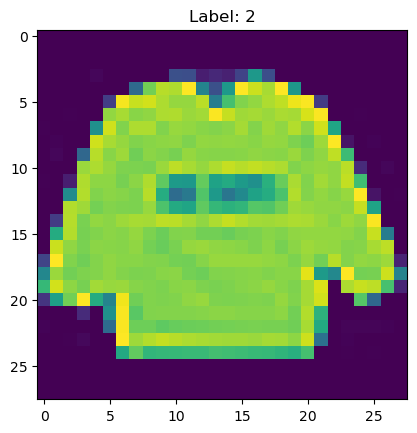

In [703]:
def show_number(X, y, index=0):
    """Display the image and label of a handwritten digit in the MNIST dataset."""

    # Show the image
    plt.imshow(X[index].reshape(28, 28))

    # Set the title of the plot to the corresponding label
    plt.title(f"Label: {y[index]}")

    # Display the plot
    plt.show()


# Example usage: display the first digit in the training set
show_number(train_X, train_y, 0)


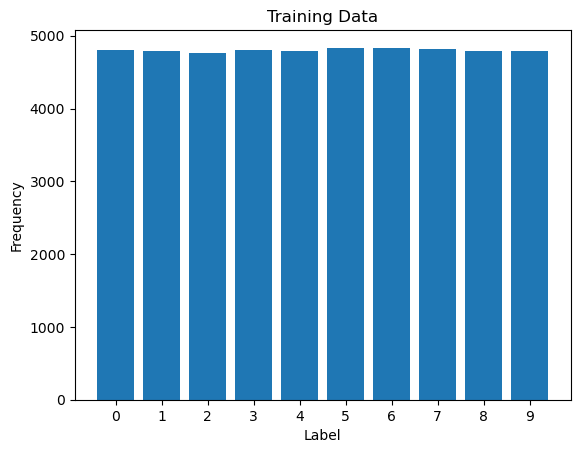

In [704]:

def plot_y_distro(y, title):
    """
    Plot the frequency distribution of labels in the input data.

    Args:
        y (ndarray): The labels of the data.
        title (str): The title of the plot.
    """
    label_counts = np.bincount(y)
    x = np.arange(len(label_counts))
    plt.bar(x, label_counts)
    plt.xticks(x)
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Label")
    plt.show()


plot_y_distro(train_y, "Training Data")


In [705]:
# Loading Test dataset
with open('fashion-mnist_test.csv', 'r') as test:
    csvtest = csv.reader(test)
    next(csvtest)
    for data in csvtest:
        Test_label = data[0]
        Test_pixels = data[1:]

In [706]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.X = x_data
        self.y = y_data
    def __len__(self):
        return len(self.y)
    # get a row at an index
    def __getitem__(self, index):
        xx = torch.from_numpy(self.X[index]).float()
        yy = torch.from_numpy(self.y[index]).float()
        return xx, yy

In [707]:
# Training Dataloader
train_data = MyDataset(train_X, train_y_one_hot)
train_args = dict(shuffle = True, batch_size = 512)
train_loader = DataLoader(train_data, **train_args)

# Validation Dataloader
val_data = MyDataset(val_X, val_y_one_hot)
val_args = dict(shuffle = False, batch_size = 256)
val_loader = DataLoader(val_data, **val_args)

In [708]:
import torch.nn as nn

class MLP(nn.Module):

    def __init__(self, size_list):
        super(MLP, self).__init__()

        self.layers = nn.ModuleDict()

        # Input layer
        self.layers['linear1'] = nn.Linear(size_list[0], size_list[1])
        self.layers['relu1'] = nn.ReLU()
        self.layers['bn1'] = nn.BatchNorm1d(size_list[1])
        self.layers['dropout1'] = nn.Dropout(0.1)

        # Hidden layers
        for i in range(1, len(size_list) - 2):
            self.layers[f'linear{i+1}'] = nn.Linear(
                size_list[i], size_list[i+1])
            self.layers[f'relu{i+1}'] = nn.ReLU()
            self.layers[f'bn{i+1}'] = nn.BatchNorm1d(size_list[i+1])
            self.layers[f'dropout{i+1}'] = nn.Dropout(0.1)

        # Output layer
        self.layers['linear_out'] = nn.Linear(size_list[-2], size_list[-1])

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x


In [709]:
model = MLP([784, 512, 256, 128, 64, 10])
print(model)

MLP(
  (layers): ModuleDict(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (relu1): ReLU()
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (relu2): ReLU()
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout(p=0.1, inplace=False)
    (linear3): Linear(in_features=256, out_features=128, bias=True)
    (relu3): ReLU()
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout3): Dropout(p=0.1, inplace=False)
    (linear4): Linear(in_features=128, out_features=64, bias=True)
    (relu4): ReLU()
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout4): Dropout(p=0.1, inplace=False)
    (linear_out): Linear(in_features=64, out_features=10, bias=True)


In [710]:
# Optimizer
Learning_Rate = 0.02
weights = model.parameters()
    # Steepest Gradient Descent 
optimizer = optim.Adagrad(weights, lr=Learning_Rate)
# Loss
criterion = nn.CrossEntropyLoss()


In [711]:
# Training
def Trainer(train_loader, model, loss, Optimizer):
    print('Training...')

    model.train()
    total_loss = 0.0
    total_predictions = 0.0
    total_correct_predictions= 0.0
    start_time = time.time()
    for i , (input,target) in enumerate(train_loader):

        # Grandient cleaning 
        model.zero_grad()
        
        # Forward Propagation
        forward = model(input)

        # Error Calculation
        error = loss(forward , target)
        
        # Back Propagation
        error.backward()

        # Update model weights
        Optimizer.step()

        predicted = torch.argmax(forward.data, dim=1)

        total_predictions += target.size(0)

        total_correct_predictions += (predicted == torch.argmax(target, dim=1)).float().sum().item()

        total_loss += error.item()
    end_time = time.time()
    total_loss /= len(train_loader)
    
    print("Training Loss = ", total_loss, " Time = ", end_time - start_time, "s")
    accuracy = (total_correct_predictions/total_predictions) * 100
    print("Training accuracy = ", accuracy, "%")
    
    return total_loss, accuracy

In [712]:
def Validator(val_loader, model, loss):

    print("Validating...")

    with torch.no_grad():

        running_loss = 0.0
        total_predictions = 0.0
        correct_prediction = 0.0
        
        # Set model in validation mode
        model.eval()
        for i, (inputs, target) in enumerate(val_loader):
            # evaluate the model on the validation set
            val_output = model(inputs)    
            # Calculate validation loss
            Loss = loss(val_output, target).detach()
            predicted = torch.argmax(val_output.data, dim=1)
            total_predictions += target.size(0)
            correct_prediction += (predicted == torch.argmax(target, dim=1)).float().sum().item()
            running_loss += Loss.item()
        running_loss /= len(val_loader)
        print("Training Loss = ", running_loss)
        acc = (correct_prediction/total_predictions) * 100
        print("Training accuracy = ", acc, "%")

        return running_loss, acc

In [713]:
epochs = 100

Train_loss = []
Test_loss = []
Test_acc = []
Train_acc = []

trial = 1

for epoch in range(epochs):

    print("Epoch Number = ", epoch)
    # Train
    training_loss, taining_acc = Trainer(train_loader, model, criterion, optimizer)
    val_loss, val_acc = Validator(train_loader, model, criterion)

    Train_loss.append(training_loss)
    Test_loss.append(val_loss)
    Test_acc.append(val_acc)
    Train_acc.append(taining_acc)

    PATH = "./trials/" + 'trial'+str(trial)+'epoch'+str(epoch)+'.pth'
    torch.save(model.state_dict(), PATH)

    # Print log of accuracy and loss
    print("Epoch: "+str(epoch)+", Training loss: "+str(training_loss)+", Validation loss:"+str(val_loss) +
          ", Validation accuracy:"+str(val_acc)+"%")
    print("="*20)


Epoch Number =  0
Training...
Training Loss =  0.5981159378239449  Time =  1.4225831031799316 s
Training accuracy =  78.38125000000001 %
Validating...
Training Loss =  0.5467542390874092
Training accuracy =  79.63958333333333 %
Epoch: 0, Training loss: 0.5981159378239449, Validation loss:0.5467542390874092, Validation accuracy:79.63958333333333%
Epoch Number =  1
Training...
Training Loss =  0.392689049243927  Time =  1.6498167514801025 s
Training accuracy =  85.80624999999999 %
Validating...
Training Loss =  0.3427428869490928
Training accuracy =  87.48541666666667 %
Epoch: 1, Training loss: 0.392689049243927, Validation loss:0.3427428869490928, Validation accuracy:87.48541666666667%
Epoch Number =  2
Training...
Training Loss =  0.3493102471879188  Time =  1.433335781097412 s
Training accuracy =  87.375 %
Validating...
Training Loss =  0.30881905222826816
Training accuracy =  88.775 %
Epoch: 2, Training loss: 0.3493102471879188, Validation loss:0.30881905222826816, Validation accurac

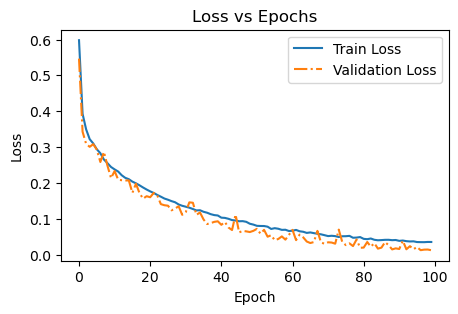

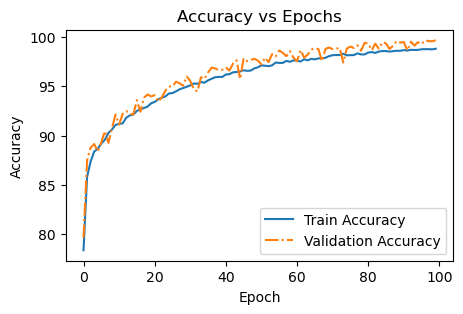

Test Accuracy:  99.64791666666667


In [714]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(len(Train_loss)), Train_loss, label='Train Loss')
plt.plot(np.arange(len(Test_loss)), Test_loss, '-.', label='Validation Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss vs Epochs')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(np.arange(len(Train_acc)), Train_acc, label='Train Accuracy')
plt.plot(np.arange(len(Test_acc)), Test_acc, '-.', label='Validation Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

# print the Test accuracy
print("Test Accuracy: ", Test_acc[-1])


In [715]:
# load the model with the lowest and highest validation accuracyand train it for 100 epochs again
model.load_state_dict(torch.load('./trials/trial1epoch99.pth'))
epochs = 50

Train_loss = []
Test_loss = []
Test_acc = []
Train_acc = []

trial = 2

for epoch in range(epochs):
    
        print("Epoch Number = ", epoch)
        # Train
        training_loss, taining_acc = Trainer(train_loader, model, criterion, optimizer)
        val_loss, val_acc = Validator(train_loader, model, criterion)
    
        Train_loss.append(training_loss)
        Test_loss.append(val_loss)
        Test_acc.append(val_acc)
        Train_acc.append(taining_acc)
    
        PATH = "./trials/" + 'trial'+str(trial)+'epoch'+str(epoch)+'.pth'
        torch.save(model.state_dict(), PATH)
    
        # Print log of accuracy and loss
        print("Epoch: "+str(epoch)+", Training loss: "+str(training_loss)+", Validation loss:"+str(val_loss) +
            ", Validation accuracy:"+str(val_acc)+"%")
        print("="*20)



Epoch Number =  0
Training...
Training Loss =  0.03460730105004412  Time =  1.2989418506622314 s
Training accuracy =  98.72708333333333 %
Validating...
Training Loss =  0.010222650125642564
Training accuracy =  99.72916666666667 %
Epoch: 0, Training loss: 0.03460730105004412, Validation loss:0.010222650125642564, Validation accuracy:99.72916666666667%
Epoch Number =  1
Training...
Training Loss =  0.03401479371724293  Time =  1.2306511402130127 s
Training accuracy =  98.76666666666667 %
Validating...
Training Loss =  0.010369282646818048
Training accuracy =  99.66041666666666 %
Epoch: 1, Training loss: 0.03401479371724293, Validation loss:0.010369282646818048, Validation accuracy:99.66041666666666%
Epoch Number =  2
Training...
Training Loss =  0.031699624675464756  Time =  1.3754940032958984 s
Training accuracy =  98.83958333333334 %
Validating...
Training Loss =  0.01836620869630195
Training accuracy =  99.33541666666666 %
Epoch: 2, Training loss: 0.031699624675464756, Validation los

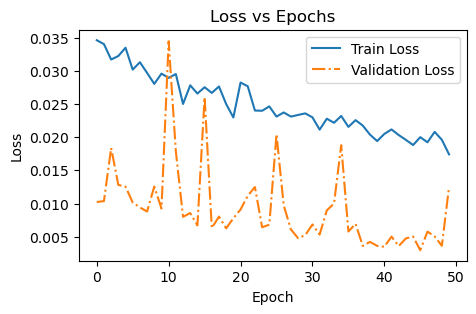

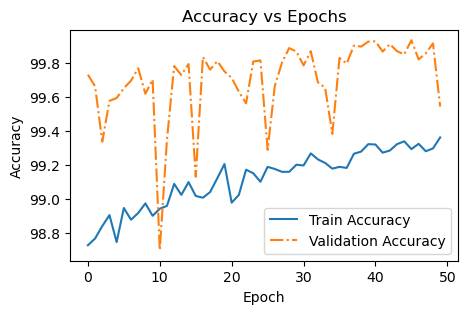

Test Accuracy:  99.54166666666666


In [723]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(len(Train_loss)), Train_loss, label='Train Loss')
plt.plot(np.arange(len(Test_loss)), Test_loss, '-.', label='Validation Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss vs Epochs')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(np.arange(len(Train_acc)), Train_acc, label='Train Accuracy')
plt.plot(np.arange(len(Test_acc)), Test_acc, '-.', label='Validation Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

# print the Test accuracy
print("Test Accuracy: ", Test_acc[-1])


In [731]:
class MLPDatasetTest(Dataset):
    def __init__(self, x_data):
        self.X = x_data
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        xx = torch.from_numpy(self.X[index]).float()
        return xx

In [732]:

# Test dataloader
test_data = MLPDatasetTest(test_X)
test_args = dict(shuffle=False, batch_size=256)
test_loader = DataLoader(test_data, **val_args)


In [733]:
# Model Creartion
model = MLP([784, 512, 256, 128, 64, 10])
model.load_state_dict(torch.load("./trials" + '/trial1epoch49.pth'))
loss = nn.CrossEntropyLoss()
#Optimizer
Optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

MLP(
  (layers): ModuleDict(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (relu1): ReLU()
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (relu2): ReLU()
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout(p=0.1, inplace=False)
    (linear3): Linear(in_features=256, out_features=128, bias=True)
    (relu3): ReLU()
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout3): Dropout(p=0.1, inplace=False)
    (linear4): Linear(in_features=128, out_features=64, bias=True)
    (relu4): ReLU()
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout4): Dropout(p=0.1, inplace=False)
    (linear_out): Linear(in_features=64, out_features=10, bias=True)


In [734]:
def final_t_model(test_loader, model):
    print("Testing...")
    with torch.no_grad():
        p = []
        # Set model in validation mode
        model.eval()
        for i, (inputs) in enumerate(test_loader):
            # evaluate the model on the validation set
            out = model(inputs)
            predicted = torch.argmax(out.data, dim=1)
            p = p + (predicted.cpu().numpy()).tolist()
        return p

MY_Final_M= final_t_model(test_loader, model)
print("Done")


Testing...
Done


In [737]:
import pandas as pd

num_records = len(MY_Final_M)
ids = list(range(num_records))
data = {'id': ids, 'Label': MY_Final_M}

df = pd.DataFrame(data=data)
df.to_csv('./submission.csv', index=False)
